In [1]:
import torch
import torchvision.datasets  as dsets
import torch.utils.data
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torchvision.utils as vutils

import tqdm
import numpy as np
import matplotlib.pyplot as plt

import os

In [2]:
image_size = 64 #64*64
batch_size = 64
num_epochs = 100
h_dim=1024
z_dim=32

dataset = dsets.ImageFolder(root="data",
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size), #根據給定size做中心裁剪(從原圖中心點剪出size*size的圖片)
                               transforms.ToTensor(),
                           ]))

data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True) #一個batch 一個batch的訓練(可以比較快)

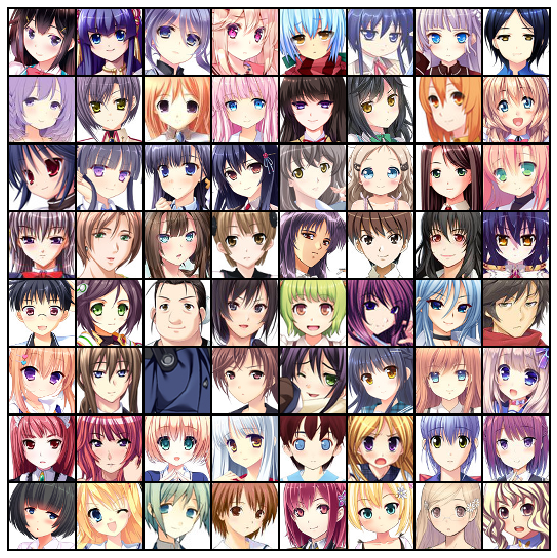

In [3]:
real_batch = next(iter(data_loader))#抓其中一個batch
plt.figure(figsize=(10, 10))
plt.axis("off")#旁邊不要有幾公分的尺規
plt.imshow(np.transpose(vutils.make_grid(real_batch[0], padding=2).cpu(),(1,2,0)))

In [4]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1) #變成一維


class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [5]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=32):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.h2mu = nn.Linear(h_dim, z_dim)
        self.h2sigma = nn.Linear(h_dim, z_dim)
        self.z2h = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(*mu.size())
        z = mu + std * eps
        return z
    
    def bottleneck(self, h):
        mu = self.h2mu(h)
        logvar = self.h2sigma(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar
        
    def encode(self, x):
        return self.bottleneck(self.encoder(x))[0]

    def decode(self, z):
        return self.decoder(self.z2h(z))
    
    def forward(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        z = self.z2h(z)
        return self.decoder(z), mu, logvar

In [6]:
def vae_loss(recon_x, x, mu, logvar) -> float:
    BCE = F.binary_cross_entropy(recon_x.view(-1, image_size*image_size*3),x.view(-1, image_size*image_size*3), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [7]:
model = VAE()
# try:
#     model.load_state_dict(torch.load('vae.pth'))
# except:
#     print("Weights not found ):")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [8]:
E = [] #存negative ELBO
for epoch in range(num_epochs):
    train_loss = 0
    for data, _ in tqdm.tqdm(data_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = vae_loss(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
    print('epoch %d, loss %.4f' % (epoch, train_loss / len(dataset)))
    E.append(train_loss / len(dataset))


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:55<00:00,  1.92it/s]


epoch 0, loss 7173.3005


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 1, loss 6681.7763


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 2, loss 6567.9219


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 3, loss 6516.2844


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 4, loss 6486.2662


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 5, loss 6467.2274


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:44<00:00,  2.05it/s]


epoch 6, loss 6456.7539


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 7, loss 6447.3323


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 8, loss 6439.7620


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 9, loss 6434.8805


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 10, loss 6428.8866


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 11, loss 6423.8960


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 12, loss 6417.7502


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 13, loss 6414.0541


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 14, loss 6410.4181


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 15, loss 6405.3036


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 16, loss 6401.4371


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 17, loss 6398.6834


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 18, loss 6394.6921


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 19, loss 6392.5731


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 20, loss 6389.9453


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 21, loss 6386.8680


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:44<00:00,  2.05it/s]


epoch 22, loss 6384.1479


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 23, loss 6382.2375


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 24, loss 6379.6038


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 25, loss 6377.9212


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 26, loss 6375.4423


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 27, loss 6375.4629


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:49<00:00,  1.99it/s]


epoch 28, loss 6372.9272


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:46<00:00,  2.02it/s]


epoch 29, loss 6370.5584


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:46<00:00,  2.03it/s]


epoch 30, loss 6369.3360


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:45<00:00,  2.04it/s]


epoch 31, loss 6368.1315


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 32, loss 6366.4484


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 33, loss 6364.7852


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 34, loss 6362.9979


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 35, loss 6362.5220


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 36, loss 6361.2202


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 37, loss 6359.5663


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 38, loss 6358.6528


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 39, loss 6357.4539


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 40, loss 6356.8398


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 41, loss 6355.6458


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 42, loss 6354.9258


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 43, loss 6353.6979


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 44, loss 6352.4533


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 45, loss 6351.6280


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 46, loss 6350.9996


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 47, loss 6350.8160


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:44<00:00,  2.04it/s]


epoch 48, loss 6349.7558


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 49, loss 6348.5993


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 50, loss 6348.7858


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:44<00:00,  2.05it/s]


epoch 51, loss 6346.7361


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 52, loss 6346.5792


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 53, loss 6345.6123


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 54, loss 6344.5835


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 55, loss 6344.4454


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 56, loss 6344.0590


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 57, loss 6343.2642


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 58, loss 6342.3550


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 59, loss 6342.9290


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 60, loss 6341.2141


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 61, loss 6340.9353


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 62, loss 6340.2483


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 63, loss 6339.5147


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 64, loss 6338.8277


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 65, loss 6338.7071


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 66, loss 6337.2441


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 67, loss 6337.7108


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 68, loss 6337.1593


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 69, loss 6336.2728


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 70, loss 6336.8222


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 71, loss 6335.2986


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 72, loss 6335.7833


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 73, loss 6334.9516


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.06it/s]


epoch 74, loss 6334.3337


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:41<00:00,  2.08it/s]


epoch 75, loss 6333.2468


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 76, loss 6333.6050


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 77, loss 6333.4018


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 78, loss 6333.3701


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 79, loss 6332.5464


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 80, loss 6333.0889


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 81, loss 6331.2144


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 82, loss 6331.2007


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 83, loss 6330.7345


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 84, loss 6330.4739


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 85, loss 6330.3464


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:41<00:00,  2.08it/s]


epoch 86, loss 6329.8259


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:43<00:00,  2.07it/s]


epoch 87, loss 6329.1489


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 88, loss 6328.9760


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 89, loss 6328.7992


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 90, loss 6328.1769


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 91, loss 6328.7565


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 92, loss 6327.5637


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 93, loss 6327.5199


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.08it/s]


epoch 94, loss 6327.4141


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 95, loss 6327.1668


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:44<00:00,  2.04it/s]


epoch 96, loss 6326.9018


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:51<00:00,  1.97it/s]


epoch 97, loss 6326.8955


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 98, loss 6326.2481


100%|████████████████████████████████████████████████████████████████████████████████| 337/337 [02:42<00:00,  2.07it/s]


epoch 99, loss 6325.9837


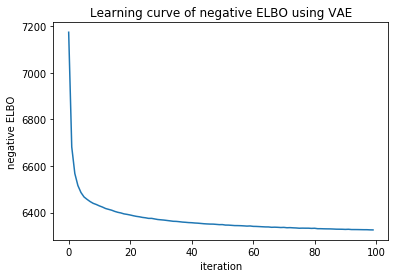

In [9]:
plt.title("Learning curve of negative ELBO using VAE")
plt.xlabel("iteration")
plt.ylabel("negative ELBO")
plt.plot(E)
plt.show()

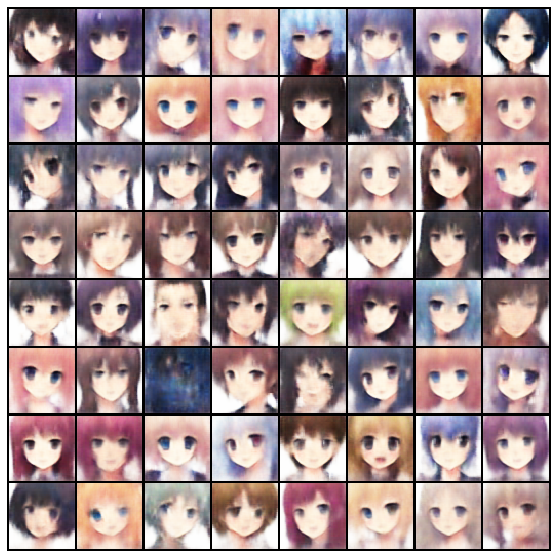

In [10]:
#劃出重構圖
decoded_batch = model.decode(model.encode(real_batch[0]).data).data
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(decoded_batch, padding=2).cpu(),(1,2,0)))

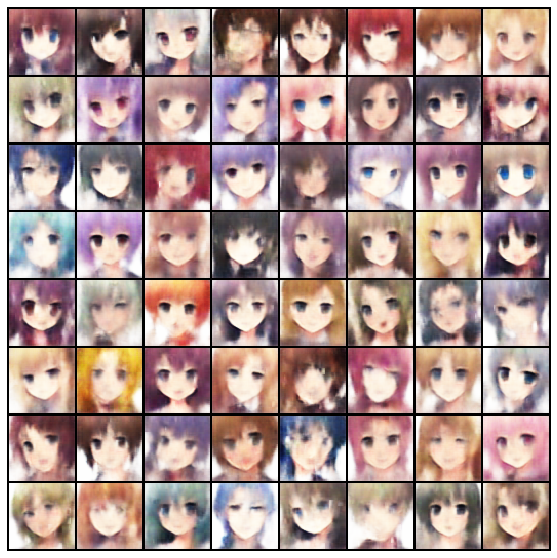

In [11]:
#隨機生成圖片
z = torch.randn(64, 32)#隨機給亂數
Syn = model.decode(z.data).data
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.imshow(np.transpose(vutils.make_grid(Syn, padding=2).cpu(),(1,2,0)))

In [12]:
def imshow(img):
    pic = np.transpose(img.numpy(), (1,2,0))
    plt.axis('off')
    return plt.imshow(pic, animated=True)

def get(x):
    return dataset[x][0].view(1, 3, image_size, image_size)
images = []#放每一張圖片
def morph(inputs, steps: int, delay: int):
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in np.linspace(0, 1, steps):
            c = a*(1-t)+b*t
            morphed = model.decode(c).data[0]
            images.append((morphed))

In [13]:
num_images = 3 # amount of images in GIF
num_steps = 5 # smoothness of transition between images
delay = 10
morph(np.random.randint(0, len(dataset), num_images), num_steps, delay)

<Figure size 432x288 with 0 Axes>

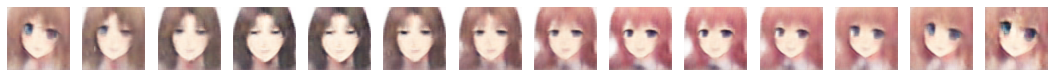

In [14]:
#印出圖片從一張變成另一張的連續過程
plt.figure(figsize=(20, 20))
for i in range(1,len(images)):
    plt.subplot(1, len(images), i)
    imshow(images[i])